In [1]:
import pandas as pd
import numpy as np
import random


In [2]:
file_path = 'ml-1m/ml-1m/movies.dat' 

try:
    df_movies = pd.read_csv(file_path, sep='::',
                     encoding='latin-1', names=['MovieID', 'Title', 'Genres'], engine='python')
    print("Fichier lu avec succès!")

except Exception as e:
    print(f"Erreur lors de la lecture du fichier : {e}")

def clean_movie_data(df_input):
    df_input.columns = ["MovieID", "Title", "Genres"]
    df_input['Year'] = df_input['Title'].str.extract(r'\((\d{4})\)', expand=False)
    df_input['Title'] = df_input['Title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)
    df_input['Genres'] = df_input['Genres'].apply(lambda x: x.split('|'))
    df_input.set_index("MovieID", inplace=True)

    return df_input

df_final = clean_movie_data(df_movies)

df_final.to_csv("movies_full_cleaned.csv")
print(df_final.head())

Fichier lu avec succès!
                               Title                            Genres  Year
MovieID                                                                     
1                          Toy Story   [Animation, Children's, Comedy]  1995
2                            Jumanji  [Adventure, Children's, Fantasy]  1995
3                   Grumpier Old Men                 [Comedy, Romance]  1995
4                  Waiting to Exhale                   [Comedy, Drama]  1995
5        Father of the Bride Part II                          [Comedy]  1995


In [3]:


df_ratings = pd.read_csv(
    'ml-1m/ml-1m/ratings.dat',
    sep='::',
    engine='python',      
    names=["UserID", "MovieID", "Rating", "Timestamp"],
    encoding='latin-1'
)

df_ratings.set_index("MovieID", inplace=True)

print(df_ratings.head())

         UserID  Rating  Timestamp
MovieID                           
1193          1       5  978300760
661           1       3  978302109
914           1       3  978301968
3408          1       4  978300275
2355          1       5  978824291


In [4]:
df_merged = pd.merge(df_movies, df_ratings, on='MovieID').reset_index()
print(df_merged.head())

   MovieID      Title                           Genres  Year  UserID  Rating  \
0        1  Toy Story  [Animation, Children's, Comedy]  1995       1       5   
1        1  Toy Story  [Animation, Children's, Comedy]  1995       6       4   
2        1  Toy Story  [Animation, Children's, Comedy]  1995       8       4   
3        1  Toy Story  [Animation, Children's, Comedy]  1995       9       5   
4        1  Toy Story  [Animation, Children's, Comedy]  1995      10       5   

   Timestamp  
0  978824268  
1  978237008  
2  978233496  
3  978225952  
4  978226474  


In [5]:

class MovieRecommender:
    def __init__(self, df, epsilon=1.0, decay=True):
        """
        df: DataFrame containing at least ['MovieID', 'Rating']
        epsilon: initial exploration rate (usually 1.0 to start with full exploration)
        decay: if True, applies an optimal decay schedule
        """
        self.df = df
        self.movie_ids = df['MovieID'].unique().tolist()
        self.K = len(self.movie_ids)

        self.epsilon_0 = epsilon
        self.epsilon = epsilon
        self.decay = decay
        self.t = 0

        # Estimated mean rewards (Q-values) initialized at 0.0
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        # Counter for the number of times each movie was selected
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        # Optimization: Group ratings by movie ID to speed up reward retrieval
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()

    def select_movie(self):
        """Action selection using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            # Exploration: choose a movie uniformly at random
            return random.choice(self.movie_ids)
        else:
            # Exploitation: choose the movie with the highest empirical mean reward
            # In case of multiple max values, max() returns the first one found
            return max(self.q_values, key=self.q_values.get)

    def get_reward(self, movie_id):
        """Simulate a reward by sampling a real rating from the dataset"""
        # Using the pre-computed dictionary for O(1) average time complexity
        return random.choice(self.ratings_dict[movie_id])

    def update_scores(self, movie_id, reward):
        """Incremental update of the empirical mean reward"""
        self.attempts[movie_id] += 1
        n = self.attempts[movie_id]
        
        # Incremental average formula: Q_n = Q_{n-1} + (1/n) * (Reward - Q_{n-1})
        old_q = self.q_values[movie_id]
        self.q_values[movie_id] = old_q + (reward - old_q) / n

    def step(self):
        """Executes one full round of the bandit algorithm"""
        self.t += 1

        # Optimal Decay Schedule:
        # According to theory (Theorem 1.6 in Slivkins), epsilon should decrease 
        # as t^(-1/3) for better regret bounds than the simple 1/t.
        if self.decay:
            # We use t^(-1/3) which is more robust for large number of arms
            self.epsilon = self.epsilon_0 * (self.t ** (-1/3))

        movie = self.select_movie()
        reward = self.get_reward(movie)
        self.update_scores(movie, reward)

        return movie, reward

    def best_movie(self):
        """Returns the movie ID with the highest estimated mean reward"""
        return max(self.q_values, key=self.q_values.get)

In [6]:
recommender = MovieRecommender(df_merged, epsilon=1.0, decay=True)

T = 5000
for _ in range(T):
    recommender.step()

best_movie = recommender.best_movie()
best_movie, recommender.q_values[best_movie]


(787, 5.0)

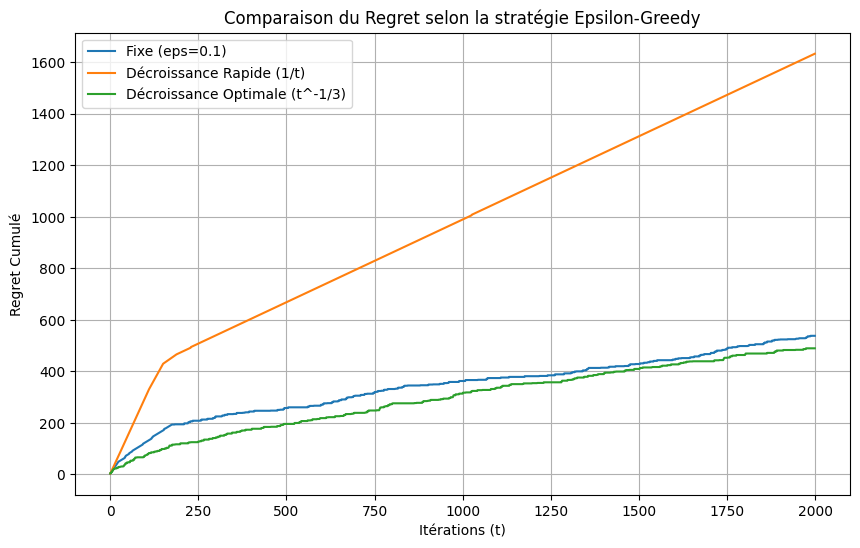

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

class MovieRecommender:
    def __init__(self, df, true_means, epsilon_init=1.0, strategy='decay_optimal'):
        self.movie_ids = list(true_means.keys())
        self.true_means = true_means # Moyennes réelles pour le calcul du regret
        self.epsilon_0 = epsilon_init
        self.epsilon = epsilon_init
        self.strategy = strategy
        self.t = 0
        
        self.q_values = {m_id: 0.0 for m_id in self.movie_ids}
        self.attempts = {m_id: 0 for m_id in self.movie_ids}
        
        # Optimisation : on groupe les notes par film pour un accès rapide
        self.ratings_dict = df.groupby('MovieID')['Rating'].apply(list).to_dict()

    def select_movie(self):
        if random.random() < self.epsilon:
            return random.choice(self.movie_ids) # Exploration
        return max(self.q_values, key=self.q_values.get) # Exploitation

    def update_epsilon(self):
        self.t += 1
        if self.strategy == 'decay_optimal':
            # Epsilon décroît en t^(-1/3) - Recommandé par Slivkins
            self.epsilon = self.epsilon_0 * (self.t ** (-1/3))
        elif self.strategy == 'decay_fast':
            # Epsilon décroît en 1/t - Très agressif
            self.epsilon = self.epsilon_0 / self.t
        elif self.strategy == 'constant':
            self.epsilon = self.epsilon_0 # Reste fixe

    def step(self):
        self.update_epsilon()
        movie = self.select_movie()
        reward = random.choice(self.ratings_dict[movie])
        
        # Mise à jour incrémentale
        self.attempts[movie] += 1
        n = self.attempts[movie]
        self.q_values[movie] += (reward - self.q_values[movie]) / n
        
        return movie

# --- SIMULATION ---

# 1. Création d'un dataset synthétique (10 films avec des moyennes différentes)
n_movies = 10
true_means = {i: random.uniform(1, 5) for i in range(n_movies)}
mu_star = max(true_means.values()) # La meilleure moyenne possible

# On génère des notes aléatoires autour de ces moyennes
data = []
for m_id, mean in true_means.items():
    notes = np.random.normal(mean, 0.5, 1000).clip(0.5, 5.0)
    for n in notes: data.append({'MovieID': m_id, 'Rating': n})
df_sim = pd.DataFrame(data)

# 2. Comparaison des stratégies
T = 2000 # Nombre d'itérations
strategies = [
    {'label': 'Fixe (eps=0.1)', 'init': 0.1, 'type': 'constant'},
    {'label': 'Décroissance Rapide (1/t)', 'init': 1.0, 'type': 'decay_fast'},
    {'label': 'Décroissance Optimale (t^-1/3)', 'init': 1.0, 'type': 'decay_optimal'}
]

plt.figure(figsize=(10, 6))

for strat in strategies:
    recommender = MovieRecommender(df_sim, true_means, strat['init'], strat['type'])
    cumulative_regret = []
    total_regret = 0
    
    for _ in range(T):
        movie_chosen = recommender.step()
        # Regret instantané = Meilleure moyenne - Moyenne du film choisi
        total_regret += (mu_star - true_means[movie_chosen])
        cumulative_regret.append(total_regret)
    
    plt.plot(cumulative_regret, label=strat['label'])

plt.xlabel('Itérations (t)')
plt.ylabel('Regret Cumulé')
plt.title('Comparaison du Regret selon la stratégie Epsilon-Greedy')
plt.legend()
plt.grid(True)
plt.savefig('regret_plot.png')